# Deconvolution for layer visualisation

Investigate deconvnets. Initially, we are copying an example that uses a VGG rather than a resnet. It is not currently clear what problems are associated with resnets, or if they can even be used for this.

This notebook reproduces the results of https://github.com/jalused/Deconvnet-keras/blob/master/Deconvnet-keras.py after converting to use TF2.2

In [56]:
%cd /home/jupyter/dev/tflow/deconvnet/Deconvnet-keras
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/jupyter/dev/tflow/deconvnet/Deconvnet-keras


In [57]:
import os
import sys
from pathlib import Path
from os import path

from Deconvnet import *
import matplotlib.pyplot as plt
import librosa


In [58]:
model = tf.keras.models.load_model("/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-49")

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 431, 128, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 431, 128, 3)       6         
_________________________________________________________________
vgg16 (Model)                (None, 13, 4, 512)        14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                12825     
Total params: 14,727,519
Trainable params: 14,727,519
Non-trainable params: 0
_______________________________________________

In [60]:
LAYER_NAME = 'block4_conv2'
deconv_layers = create_deconv(model, LAYER_NAME)

input_3
conv2d_1
vgg16
input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2


In [61]:
deconv_layers

In [62]:
def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)   
    #S = librosa.feature.melspectrogram(y=y, sr=sr)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        fmax=(sr / 2.0),
        fmin=0.0,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )
    S = librosa.power_to_db(S)
    S = np.transpose(S)
    return S[np.newaxis, 0:431, :, np.newaxis]

In [63]:
def main(filepath, feature_to_visualize, visualize_mode='all'):

    # Load data and preprocess
    #img = Image.open(image_path)
    #img = img.resize((224, 224))
    #img_array = np.array(img)
    #img_array = img_array[np.newaxis, :]
    #img_array = img_array.astype(np.float)
    #img_array = imagenet_utils.preprocess_input(img_array)
    
    data = extract_feature(filepath)
    deconv = visualize(deconv_layers, data, 
            feature_to_visualize, visualize_mode)
    
    return deconv

In [64]:
recordings_dir = "/home/jupyter/dev/tflow/unit_test_files"

In [65]:
result = main(path.join(recordings_dir,"vacuum_cleaner.wav"), 46)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
d: 23
d: 22
d: 21
d: 20
d: 19
d: 18
d: 17
d: 16
d: 15
d: 14
d: 13
d: 12
d: 11
d: 10
d: 9
d: 8
d: 7
d: 6
d: 5
d: 4
d: 3
d: 2
d: 1
d: 0


In [66]:
import librosa.display
def generate_image(spectro):
    spectro = np.rot90(spectro)
    spectro = spectro[::-1,:]
    plt.axis('off')
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(spectro)
    plt.plot()

In [203]:
def show_image(spectro, cmap='gray'):
    _,ax = plt.subplots(figsize=(10,10))

    spectro = np.rot90(spectro)
    ax.axis('off')
    #ax.set_title(f"{layers[i]}:")
    ax.imshow(spectro, cmap=cmap)
    #ax.imshow(spectro)


In [67]:
def forward_pass(deconv_layers, data):
    # Forward pass
    deconv_layers[0].up(data)
    for i in range(1, len(deconv_layers)):
        print(f"{i}")
        #print(f"{i}: {deconv_layers[i].name}")
        deconv_layers[i].up(deconv_layers[i - 1].up_data)

    return deconv_layers[-1].up_data

In [68]:
output = forward_pass(deconv_layers, extract_feature(path.join(recordings_dir,"vacuum_cleaner.wav")))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [69]:
def backward_pass(deconv_layers, output, feature_to_visualize, visualize_mode):
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:, :, :, feature_to_visualize]
    if 'max' == visualize_mode:
        feature_map = feature_map.numpy()
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
    elif 'all' != visualize_mode:
        print('Illegal visualize mode')
        sys.exit()
    output = np.zeros_like(output)
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:, :, :, feature_to_visualize] = feature_map

    # Backward pass
    deconv_layers[-1].down(output)
    for i in range(len(deconv_layers) - 2, -1, -1):
        #print(f"d: {i}")
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()
    
    return deconv

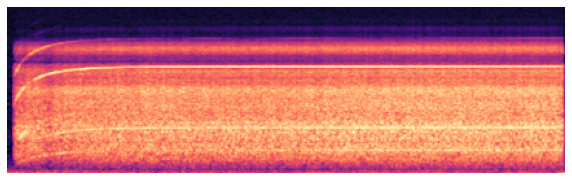

In [207]:
s = extract_feature(path.join(recordings_dir,"vacuum_cleaner.wav"))
show_image(s[0,:,:,0],'magma')

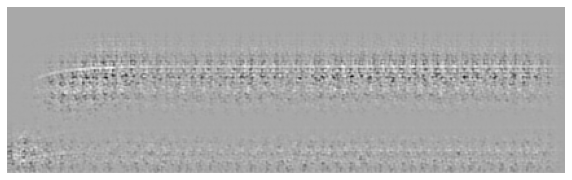

In [205]:
result = backward_pass(deconv_layers, output, 46, 'all')
show_image(result)

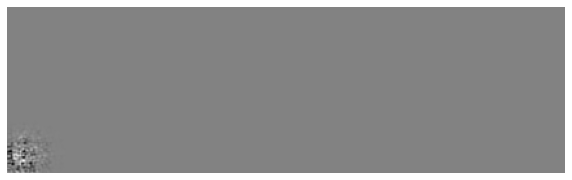

In [199]:
result = backward_pass(deconv_layers, output, 46, 'max')
show_image(result)

In [200]:
def max_activation(output):
    a = np.mean(np.mean(output[0,:,:,:],axis=0), axis=0)
    return (-a).argsort()

def multiplot(layers, mode='all', rows=4, cols=2):
    _,axes = plt.subplots(rows,cols,figsize=(15,10))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(layers):
            break
        r = backward_pass(deconv_layers, output, layers[i], mode)
        spectro = np.rot90(r)
        #spectro = spectro[::-1,:]
        ax.axis('off')
        ax.set_title(f"{layers[i]}:")
        ax.imshow(spectro, cmap='gray')


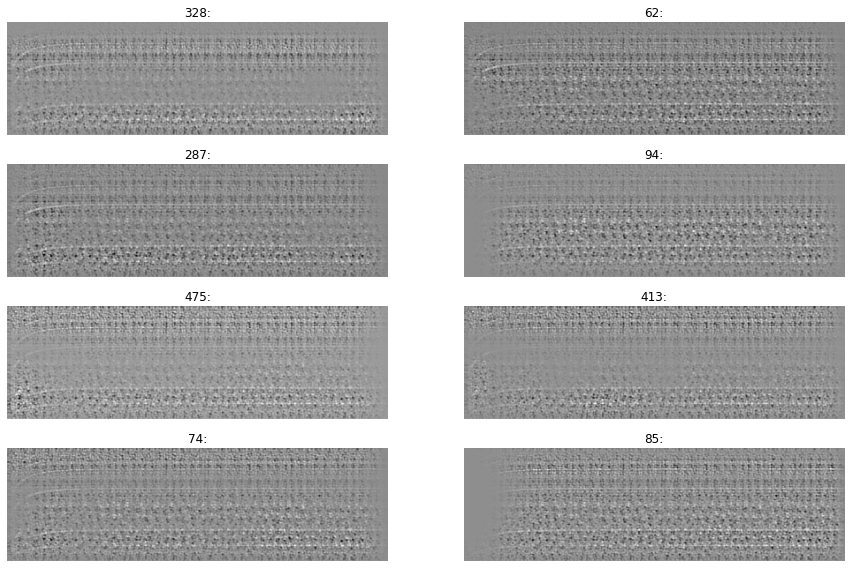

In [201]:
max_act = max_activation(output)
multiplot(max_act[:8])

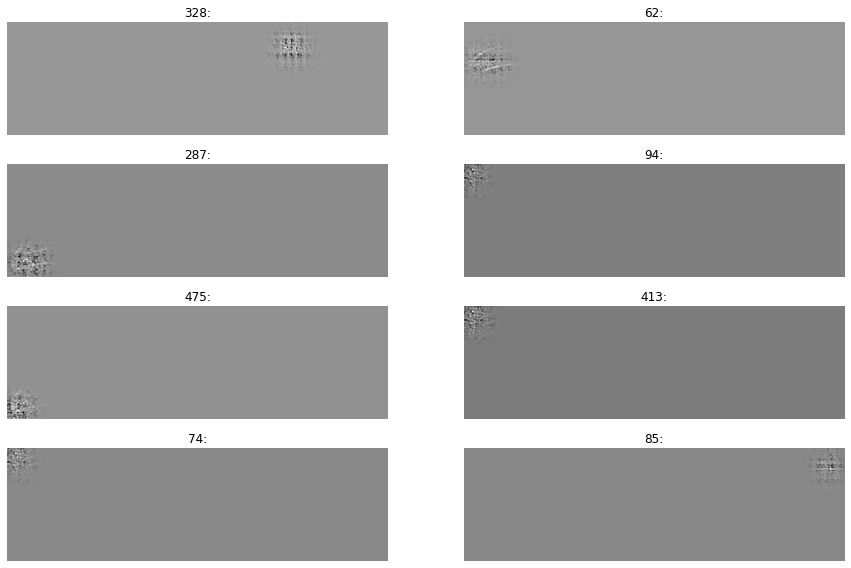

In [202]:
multiplot(max_act[:8],'max')